## Titanic - Machine Learning from Disaster

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
from collections import Counter
from string import punctuation
from typing import Tuple

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score, precision_recall_curve, RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

### Загрузка датасетов

#### Признаки:

*  **PassengerId** - номер пассажира, равен индексу
*  **Survived** - целевая переменная 0 - не выжил, 1 - выжил
*  **Pclass** - класс билета 1 = 1st, 2 = 2nd, 3 = 3rd
*  **Name** - имя пассажира
*  **Sex** - пол пассажира
*  **Age** - возраст пассажира (дробен, если меньше 1)
*  **SibSp** - количество братьев/сестер (в том числе сводных) и мужей/жен пассажира находившихся на борту
*  **Parch** - количесвто родителей и детей (включая пасынков/падчериц) пассжира на борту
*  **Ticket** - номер билета
*  **Fare** - стоимость билета
*  **Cabin** - номер каюты
*  **Embarked** - порт посадки C = Cherbourg, Q = Queenstown, S = Southampton

In [2]:
df = pd.read_csv('data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
print(df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


#### Баланс классов

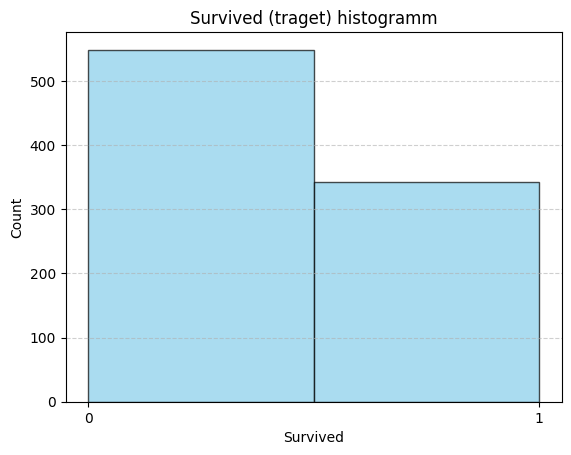

In [5]:
plt.hist(df['Survived'], bins=2,  color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks([0, 1])
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Survived (traget) histogramm')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Посмотрим на признаки

#### Признак Age

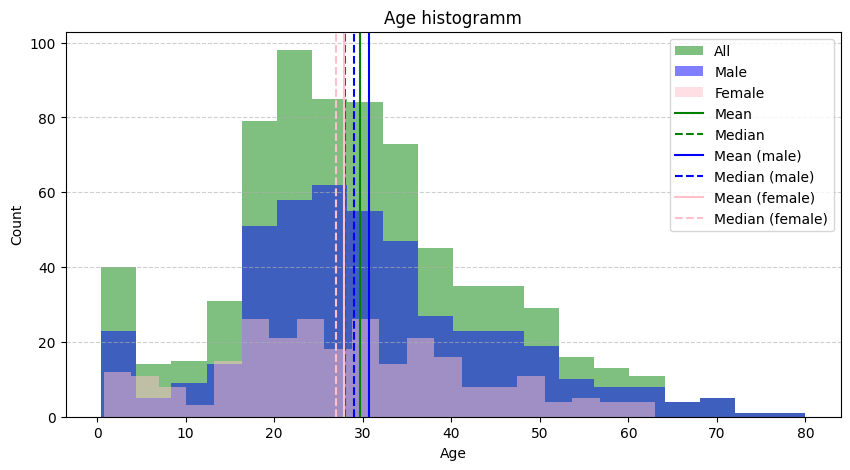

In [6]:
plt.figure(figsize=(10, 5))
plt.hist(df['Age'], bins=20, label='All', alpha=0.5, color='green')
plt.hist(df[df['Sex'] == 'male']['Age'], bins=20, label='Male', alpha=0.5, color='blue')
plt.hist(df[df['Sex'] == 'female']['Age'], bins=20, label='Female', alpha=0.5, color='pink')
plt.axvline(x=df['Age'].mean(), color='green', label='Mean')
plt.axvline(x=df['Age'].median(), color='green', label='Median', linestyle='--')
plt.axvline(x=df[df['Sex'] == 'male']['Age'].mean(), color='blue', label='Mean (male)')
plt.axvline(x=df[df['Sex'] == 'male']['Age'].median(), color='blue', label='Median (male)', linestyle='--')
plt.axvline(x=df[df['Sex'] == 'female']['Age'].mean(), color='pink', label='Mean (female)')
plt.axvline(x=df[df['Sex'] == 'female']['Age'].median(), color='pink', label='Median (female)', linestyle='--')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age histogramm')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

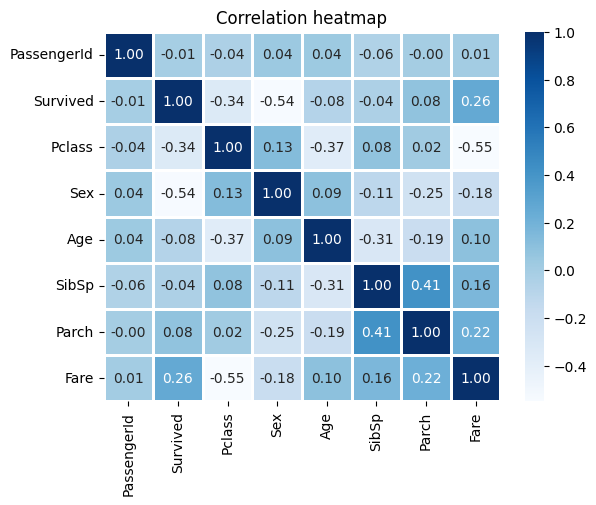

In [7]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
ax = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()
df['Sex'] = df['Sex'].apply(lambda x: 'male' if x == 1 else 'female')

##### Для признака `Age` не было выявлено каких-дибо интересных закономерностей - заполним пропуски средним по всему датасету

#### Признак `Cabin`

<img src="https://library.vladimir.ru/wp-content/uploads/2022/04/Titanic_palyb.jpeg" style="max-width: 270px; height: 425px; margin: 0px; width: 270px;">

In [8]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [9]:
cabind = {sym : i + 1 for i, sym in enumerate('ABCDEFG')}

In [10]:
df['floor'] = df['Cabin'].apply(lambda x: cabind.get(str(x)[0], 0))
df['cab_num'] = df['Cabin'].apply(lambda x: int(re.sub(pattern='\\D', repl='', string=str(x).split()[0])) if any(char.isdigit() for char in str(x).split()[0]) else 0)

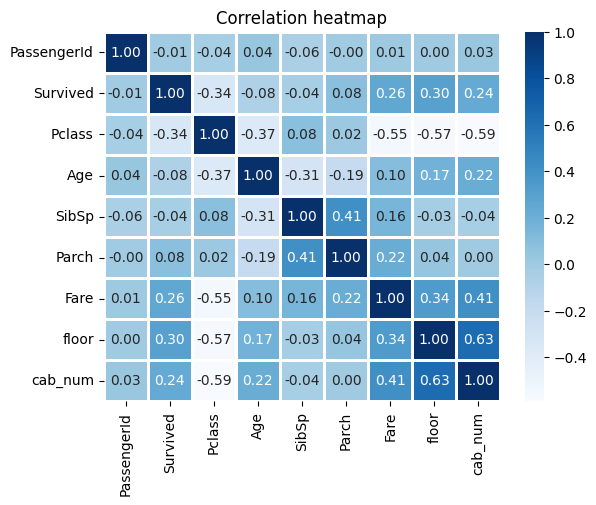

In [11]:
ax = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [12]:
df.drop('floor', axis=1, inplace=True)
df.drop('cab_num', axis=1, inplace=True)

##### Целесообразным будет заменить `Cabin` на два новых признака - палуба и номер каюты

#### Признак `Embarked`

In [13]:
df['Embarked_num'] = df['Embarked'].apply(lambda x: 'SQC'.find(str(x)) if str(x) else -1)

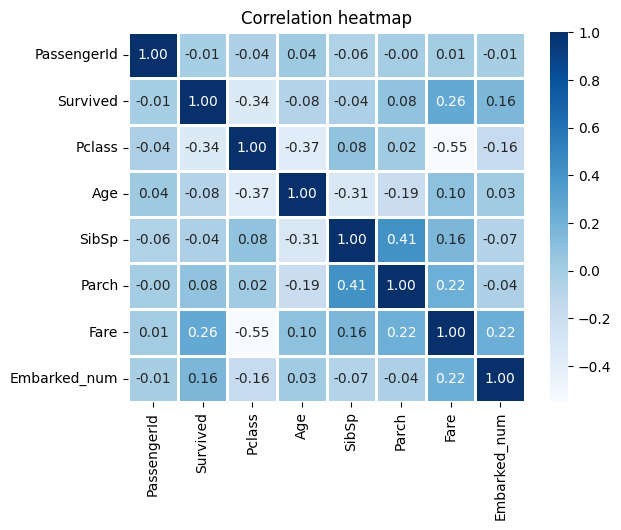

In [14]:
ax = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

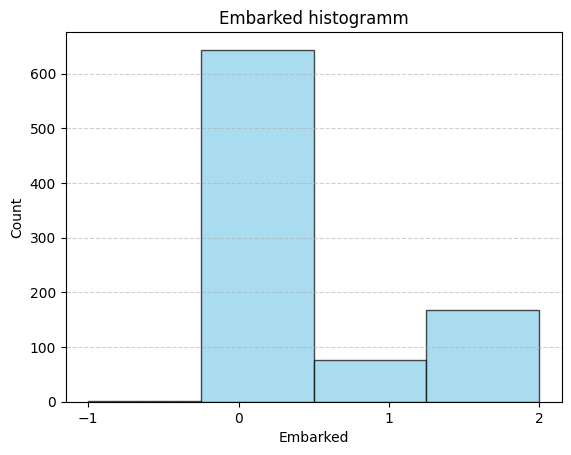

In [15]:
plt.hist(df['Embarked_num'], bins=4,  color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks([-1, 0, 1, 2])
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.title('Embarked histogramm')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [16]:
df.drop('Embarked_num', axis=1, inplace=True)

##### Признак `Embarked` не очень информативен, возможно его не стоит рассматривать

#### Признак `SibSp` и `Parch`

In [17]:
df['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [18]:
df['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

In [19]:
df['Alone'] = df[['SibSp', 'Parch']].apply(lambda x: 1 if x['SibSp'] == 0 and x['Parch'] == 0 else 0, axis=1)
df['Parents'] = df['Parch'].apply(lambda x: min(1, x))

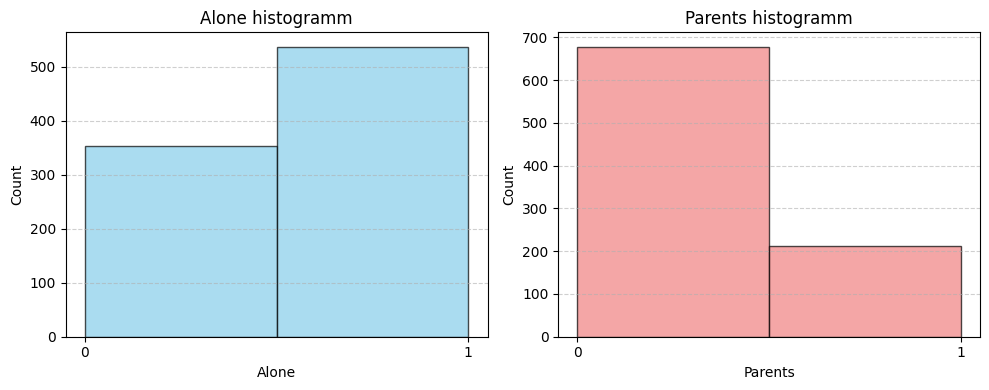

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(df['Alone'], bins=2, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xticks([0, 1])
ax1.set_xlabel('Alone')
ax1.set_ylabel('Count')
ax1.set_title('Alone histogramm')
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2.hist(df['Parents'], bins=2, color='lightcoral', edgecolor='black', alpha=0.7)
ax2.set_xticks([0, 1])
ax2.set_xlabel('Parents')
ax2.set_ylabel('Count')
ax2.set_title('Parents histogramm')
ax2.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

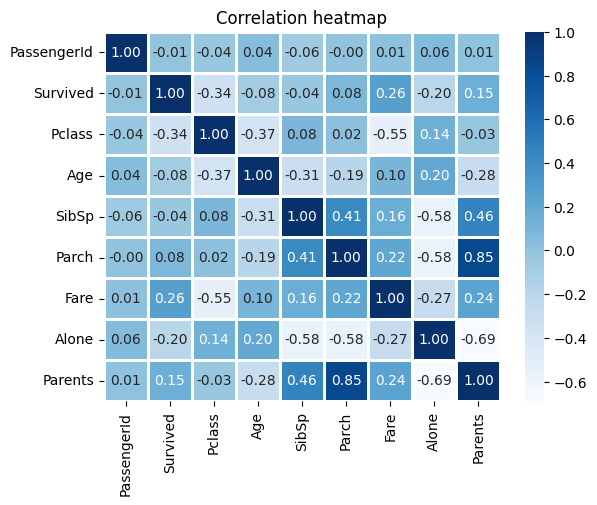

In [21]:
ax = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [22]:
df.drop('Alone', axis=1, inplace=True)
df.drop('Parents', axis=1, inplace=True)

##### Стоит сделать признаки `SibSp` и `Parch` бинарными

#### Признак `Name`

In [23]:
tokens = []
for name in df['Name'].unique():
    tokens.extend(word_tokenize(name.lower()))

c = Counter(tokens)

stop_words = set(stopwords.words('english'))

keys_to_delete = [key for key in c.keys() if key in punctuation]
for key in keys_to_delete:
    del c[key]

c.most_common(20)

[('mr.', 517),
 ('miss', 182),
 ('mrs.', 125),
 ('william', 64),
 ('``', 53),
 ("''", 53),
 ('john', 44),
 ('master', 40),
 ('henry', 35),
 ('james', 24),
 ('george', 24),
 ('charles', 23),
 ('thomas', 22),
 ('mary', 20),
 ('edward', 18),
 ('anna', 17),
 ('joseph', 16),
 ('elizabeth', 15),
 ('johan', 15),
 ('frederick', 15)]

In [24]:
df['has_mr'] = df['Name'].apply(lambda x: 1 if 'mr' in x.lower() else 0)
df['has_miss'] = df['Name'].apply(lambda x: 1 if 'miss' in x.lower() else 0)
df['has_mrs'] = df['Name'].apply(lambda x: 1 if 'mrs' in x.lower() else 0)
df['has_master'] = df['Name'].apply(lambda x: 1 if 'master' in x.lower() else 0)

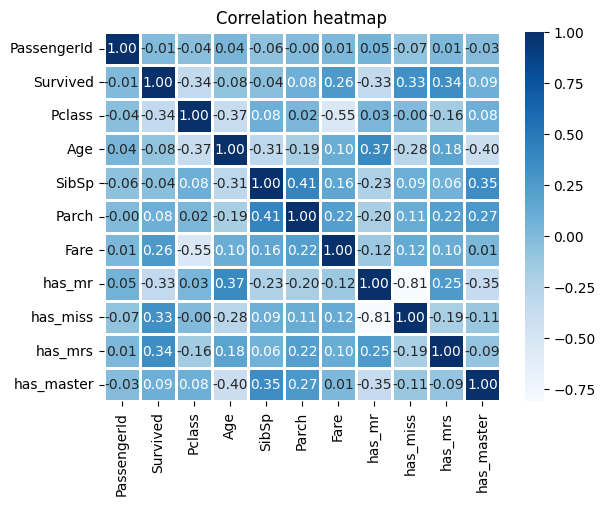

In [25]:
ax = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [26]:
len(df[(df['has_master'] == 0) & (df['has_mr'] == 0) & (df['has_mrs'] == 0) & (df['has_miss'])])

180

In [27]:
df.drop('has_mr', axis=1, inplace=True)
df.drop('has_miss', axis=1, inplace=True)
df.drop('has_mrs', axis=1, inplace=True)
df.drop('has_master', axis=1, inplace=True)

#### Признак `Ticket`

In [28]:
df['has_letters'] = df['Ticket'].apply(lambda x: 0 if str(x).strip().isdigit() else 1)

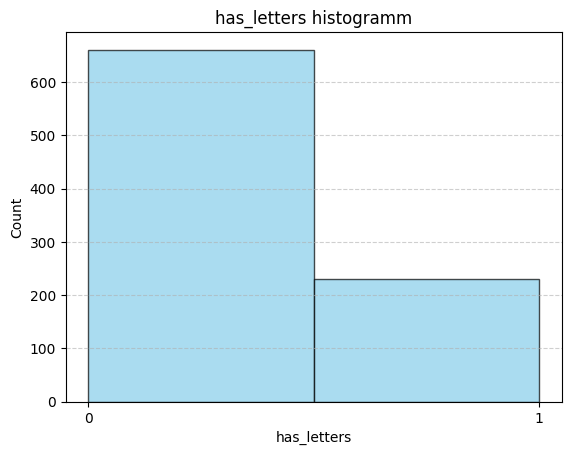

In [29]:
plt.hist(df['has_letters'], bins=2,  color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks([0, 1])
plt.xlabel('has_letters')
plt.ylabel('Count')
plt.title('has_letters histogramm')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

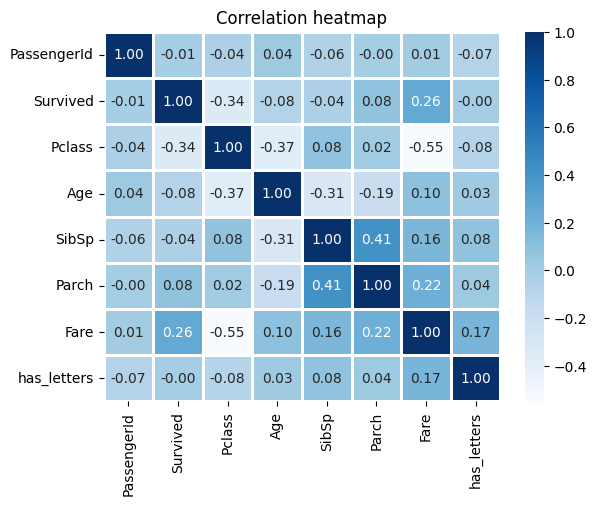

In [30]:
ax = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [31]:
df.drop('has_letters', axis=1, inplace=True)

#### Признак `Fare`

In [32]:
df['Fare_bins'] = pd.qcut(df['Fare'], q=5, labels=False)

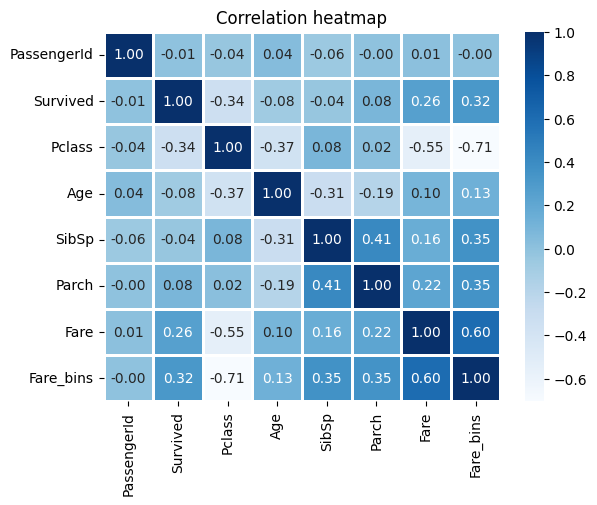

In [33]:
ax = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

#### Итоговый препроцессинг

In [35]:
def fill_age(train, test):
    mean_age = round(train['Age'].mean(), 0)
    train['Age'] = train['Age'].fillna(mean_age)
    test['Age'] = test['Age'].fillna(mean_age)
    return train, test

def process_sex(train, test):
    for df in (train, test):
        df['Male'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
        df.drop('Sex', axis=1, inplace=True)
    return train, test

def process_cabin(train, test):
    cabind = {sym : i+1 for i, sym in enumerate('ABCDEFGT')}
    for df in (train, test):
        df['Floor'] = df['Cabin'].apply(lambda x: cabind.get(str(x)[0], 0))
        df['Cab_num'] = df['Cabin'].apply(
            lambda x: int(re.sub('\\D', '', str(x).split()[0])) if any(ch.isdigit() for ch in str(x).split()[0]) else 0
        )
        df.drop('Cabin', axis=1, inplace=True)
    return train, test

def process_embarked(train, test):
    mapping = {'S':0, 'Q':1, 'C':2}
    for df in (train, test):
        df['Embarked_num'] = df['Embarked'].map(mapping).fillna(0).astype(int)
        df.drop('Embarked', axis=1, inplace=True)
    return train, test

def process_family(train, test):
    for df in (train, test):
        df['Alone'] = ((df['SibSp']==0) & (df['Parch']==0)).astype(int)
        df['Parents'] = df['Parch'].clip(upper=1)
        df.drop(['SibSp','Parch'], axis=1, inplace=True)
    return train, test

def process_name(train, test):
    for df in (train, test):
        df['has_mr'] = df['Name'].str.lower().str.contains('mr').astype(int)
        df['has_miss'] = df['Name'].str.lower().str.contains('miss').astype(int)
        df['has_mrs'] = df['Name'].str.lower().str.contains('mrs').astype(int)
        df.drop('Name', axis=1, inplace=True)
    return train, test

def process_fare(train, test):
    train['Fare_bins'], bin_edges = pd.qcut(train['Fare'], q=5, labels=False, retbins=True, duplicates='drop')
    test['Fare_bins'] = pd.cut(test['Fare'], bins=bin_edges, labels=False, include_lowest=True)
    for df in (train, test):
        df.drop('Fare', axis=1, inplace=True)
    return train, test

def preprocessing(train_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train, test = train_df.copy(), test_df.copy()
    for func in (fill_age, process_sex, process_cabin, process_embarked, process_family, process_name, process_fare):
        train, test = func(train, test)
    for feature in ['PassengerId', 'Ticket']:
        train.drop(feature, axis=1, inplace=True)
        test.drop(feature, axis=1, inplace=True)
    return train, test

In [36]:
newdf, _ = preprocessing(df, df.copy())

In [37]:
newdf

,Survived,Pclass,Age,Fare_bins,Male,Floor,Cab_num,Embarked_num,Alone,Parents,has_mr,has_miss,has_mrs
0,0,3,22.0,0,1,0,0,0,0,0,1,0,0
1,1,1,38.0,4,0,3,85,2,0,0,1,0,1
2,1,3,26.0,1,0,0,0,0,1,0,0,1,0
3,1,1,35.0,4,0,3,123,0,0,0,1,0,1
4,0,3,35.0,1,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,2,1,0,0,0,1,0,0,0,0
887,1,1,19.0,3,0,2,42,0,1,0,0,1,0
888,0,3,30.0,3,0,0,0,0,0,1,0,1,0
889,1,1,26.0,3,1,3,148,2,1,0,1,0,0


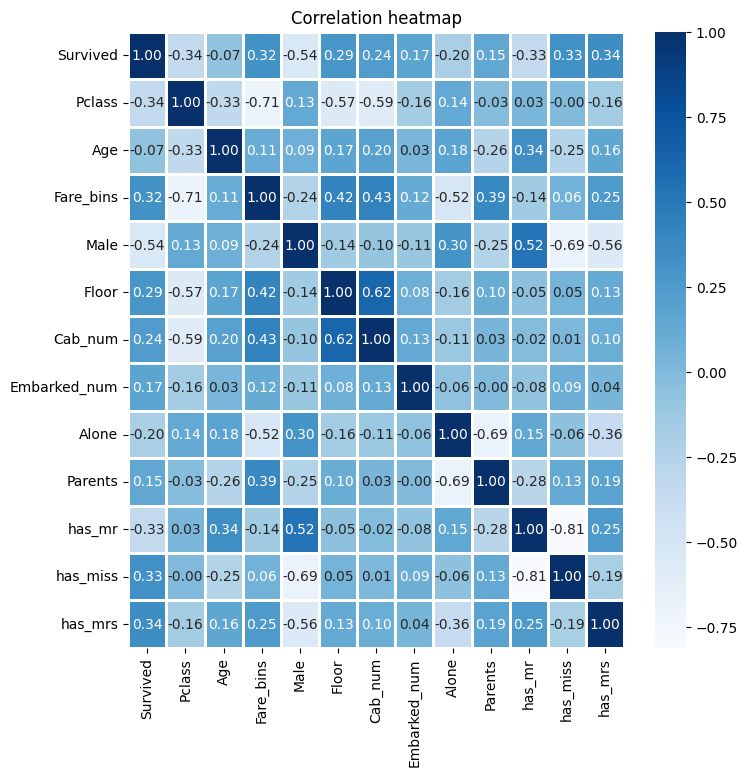

In [38]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(newdf.corr(), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

#### Заново загрузим данные, разделим их на train/test

In [39]:
df = pd.read_csv('data/train.csv')
train_df_orig, test_df = train_test_split(df, test_size=0.3, random_state=33, stratify=df['Survived'])

In [40]:
train_df, test_df = preprocessing(train_df_orig, test_df)

In [41]:
train_df.isna().sum().sum() == 0 == test_df.isna().sum().sum()

np.True_

In [42]:
X_train, y_train = train_df.drop('Survived', axis=1), train_df['Survived']
X_test, y_test = test_df.drop('Survived', axis=1), test_df['Survived']

### Baseline 1 - RandomForest

In [43]:
base_rf = RandomForestClassifier(n_estimators=150, random_state=14)
base_rf.fit(X_train, y_train)
base_rf_train_preds, base_rf_train_probs = base_rf.predict(X_train), base_rf.predict_proba(X_train)
base_rf_test_preds, base_rf_test_probs = base_rf.predict(X_test), base_rf.predict_proba(X_test)

In [44]:
print(f'RF Train accuracy score = {accuracy_score(y_train, base_rf_train_preds):.2f}')
print(f'RF Train precision score = {precision_score(y_train, base_rf_train_preds):.2f}')
print(f'RF Train recall score = {recall_score(y_train, base_rf_train_preds):.2f}')
print(f'RF Test accuracy score = {accuracy_score(y_test, base_rf_test_preds):.2f}')
print(f'RF Test precision score = {precision_score(y_test, base_rf_test_preds):.2f}')
print(f'RF Test recall score = {recall_score(y_test, base_rf_test_preds):.2f}')

RF Train accuracy score = 0.97
RF Train precision score = 0.99
RF Train recall score = 0.92
RF Test accuracy score = 0.82
RF Test precision score = 0.76
RF Test recall score = 0.77


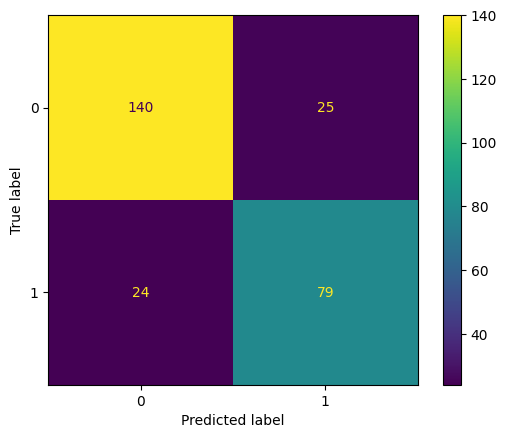

In [45]:
ConfusionMatrixDisplay.from_estimator(base_rf, X_test, y_test)
plt.show()

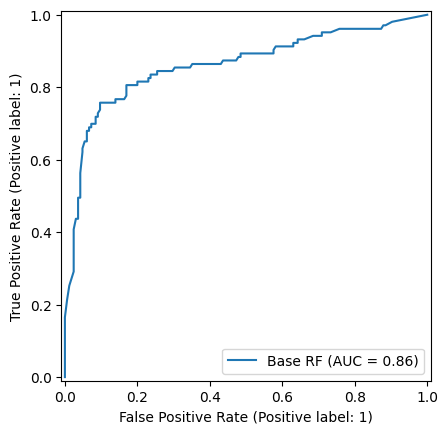

In [46]:
RocCurveDisplay.from_estimator(base_rf, X_test, y_test, name='Base RF')
plt.show()

### Baseline 2 - LogReg

In [47]:
base_logreg = LogisticRegression(max_iter=10000)
base_logreg.fit(X_train, y_train)
base_logreg_train_preds, base_logreg_train_probs = base_logreg.predict(X_train), base_rf.predict_proba(X_train)
base_logreg_test_preds, base_logreg_test_probs = base_logreg.predict(X_test), base_rf.predict_proba(X_test)

In [48]:
print(f'LogReg Train accuracy score = {accuracy_score(y_train, base_logreg_train_preds):.2f}')
print(f'LogReg Train precision score = {precision_score(y_train, base_logreg_train_preds):.2f}')
print(f'LogReg Train recall score = {recall_score(y_train, base_logreg_train_preds):.2f}')
print(f'LogReg Test accuracy score = {accuracy_score(y_test, base_logreg_test_preds):.2f}')
print(f'LogReg Test precision score = {precision_score(y_test, base_logreg_test_preds):.2f}')
print(f'LogReg Test recall score = {recall_score(y_test, base_logreg_test_preds):.2f}')

LogReg Train accuracy score = 0.82
LogReg Train precision score = 0.78
LogReg Train recall score = 0.75
LogReg Test accuracy score = 0.82
LogReg Test precision score = 0.76
LogReg Test recall score = 0.78


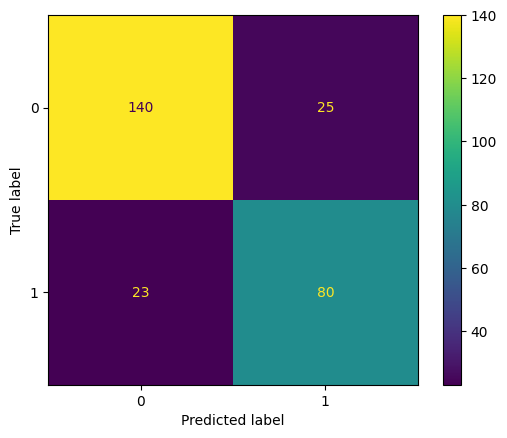

In [49]:
ConfusionMatrixDisplay.from_estimator(base_logreg, X_test, y_test)
plt.show()

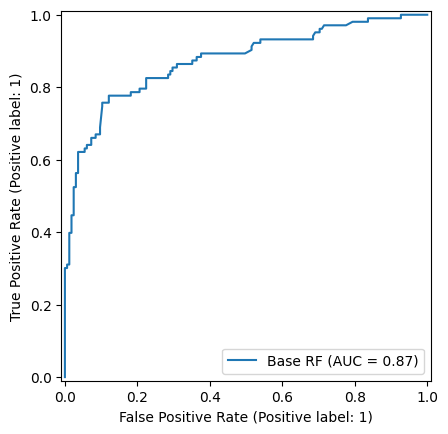

In [50]:
RocCurveDisplay.from_estimator(base_logreg, X_test, y_test, name='Base RF')
plt.show()

##### Поработаем с RandomForest

In [51]:
rf_param_grid = {
    'n_estimators' : [100, 150, 200, 250, 300],
    'min_samples_split' : [2, 3, 4, 5],
    'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
    'criterion' : ['gini', 'entropy']
}

rf = RandomForestClassifier()

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    n_jobs=-1,
    scoring='accuracy',
    cv=3,
    verbose=1
)

rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='accuracy', verbose=1)

In [52]:
rf_search.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 100}

In [53]:
rf = rf_search.best_estimator_
rf_train_preds, rf_train_probs = rf.predict(X_train), rf.predict_proba(X_train)
rf_test_preds, rf_test_probs = rf.predict(X_test), rf.predict_proba(X_test)

In [54]:
print(f'RF Train accuracy score = {accuracy_score(y_train, rf_train_preds):.2f}')
print(f'RF Train precision score = {precision_score(y_train, rf_train_preds):.2f}')
print(f'RF Train recall score = {recall_score(y_train, rf_train_preds):.2f}')
print(f'RF Test accuracy score = {accuracy_score(y_test, rf_test_preds):.2f}')
print(f'RF Test precision score = {precision_score(y_test, rf_test_preds):.2f}')
print(f'RF Test recall score = {recall_score(y_test, rf_test_preds):.2f}')

RF Train accuracy score = 0.89
RF Train precision score = 0.89
RF Train recall score = 0.82
RF Test accuracy score = 0.81
RF Test precision score = 0.76
RF Test recall score = 0.76


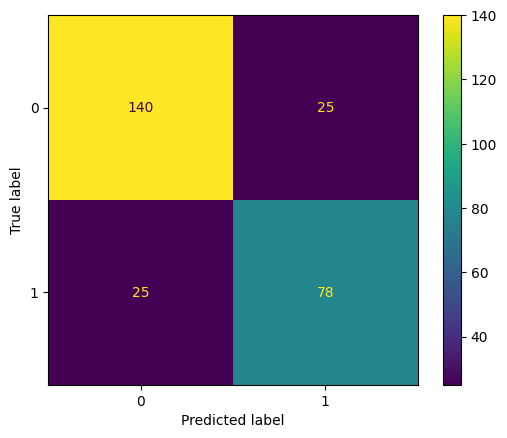

In [55]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.show()

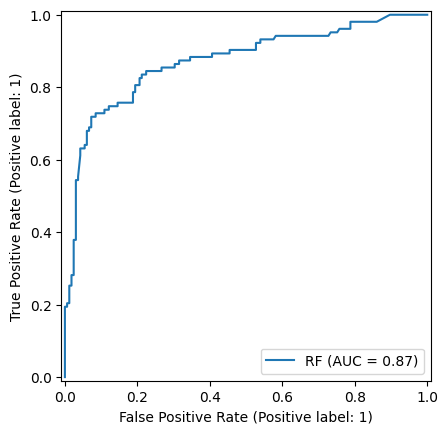

In [56]:
RocCurveDisplay.from_estimator(rf, X_test, y_test, name='RF')
plt.show()

##### Поработаем с LogReg

In [59]:
X_train_logreg = X_train.copy()
X_test_logreg = X_test.copy()
scaler = MinMaxScaler()
scaler.fit(X_train_logreg[['Age']])

X_train_logreg[['Age']] = scaler.transform(X_train_logreg[['Age']])
X_train_logreg['Cab_num'], bins = pd.qcut(X_train_logreg['Cab_num'], q=5, labels=False, retbins=True, duplicates='drop')
X_train_logreg.loc[X_train['Cab_num'] == 0, 'Cab_num'] = -1

X_test_logreg[['Age']] = scaler.transform(X_test_logreg[['Age']])
X_test_logreg['Cab_num'] = pd.cut(X_test_logreg['Cab_num'], bins=bins, labels=False, duplicates='drop')
X_test_logreg.loc[X_test['Cab_num'] == 0, 'Cab_num'] = -1

In [60]:
category_map = {
    'Pclass': [1, 2, 3],
    'Floor': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'Cab_num': [-1, 0, 1, 2, 3, 4],
    'Embarked_num': [0, 1, 2],
    'Fare_bins': [0, 1, 2, 3, 4]
}

def enforce_categories(df, column, allowed_categories):
    default_category = allowed_categories[0]
    df[column] = df[column].apply(lambda x: x if x in allowed_categories else default_category)
    return df

for col, categories in category_map.items():
    X_train_logreg = enforce_categories(X_train_logreg, col, categories)
    X_test_logreg = enforce_categories(X_test_logreg, col, categories)

columns_to_encode = ['Pclass', 'Floor', 'Cab_num', 'Embarked_num', 'Fare_bins']
ohe = OneHotEncoder(sparse_output=False, categories=[category_map[col] for col in columns_to_encode], handle_unknown='error')

X_train_encoded = pd.DataFrame(
    ohe.fit_transform(X_train_logreg[columns_to_encode]),
    columns=ohe.get_feature_names_out(columns_to_encode),
    index=X_train_logreg.index
)

X_test_encoded = pd.DataFrame(
    ohe.transform(X_test_logreg[columns_to_encode]),
    columns=ohe.get_feature_names_out(columns_to_encode),
    index=X_test_logreg.index
)

X_train_logreg = X_train_logreg.drop(columns=columns_to_encode)
X_test_logreg = X_test_logreg.drop(columns=columns_to_encode)

X_train_logreg = pd.concat([X_train_logreg, X_train_encoded], axis=1)
X_test_logreg = pd.concat([X_test_logreg, X_test_encoded], axis=1)

In [61]:
import warnings
warnings.filterwarnings('ignore')

logreg_param_grid = {
    'tol' : [0.0001, 0.0005, 0.001],
    'C' : [0.1, 0.3, 0.5, 0.8, 1, 1.2],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty' : ['l1', 'l2', 'elasticnet']
}

logreg = LogisticRegression(max_iter=20_000)

logreg_search = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_param_grid,
    n_jobs=-1,
    cv=10,
    verbose=0
)

logreg_search.fit(X_train_logreg, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=20000), n_jobs=-1,
             param_grid={'C': [0.1, 0.3, 0.5, 0.8, 1, 1.2],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga'],
                         'tol': [0.0001, 0.0005, 0.001]})

In [62]:
logreg_search.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}

In [63]:
logreg = logreg_search.best_estimator_
logreg_train_preds, logreg_train_probs = logreg.predict(X_train_logreg), logreg.predict_proba(X_train_logreg)
logreg_test_preds, logreg_test_probs = logreg.predict(X_test_logreg), logreg.predict_proba(X_test_logreg)

In [64]:
print(f'LogReg Train accuracy score = {accuracy_score(y_train, logreg_train_preds):.2f}')
print(f'LogReg Train precision score = {precision_score(y_train, logreg_train_preds):.2f}')
print(f'LogReg Train recall score = {recall_score(y_train, logreg_train_preds):.2f}')
print(f'LogReg Test accuracy score = {accuracy_score(y_test, logreg_test_preds):.2f}')
print(f'LogReg Test precision score = {precision_score(y_test, logreg_test_preds):.2f}')
print(f'LogReg Test recall score = {recall_score(y_test, logreg_test_preds):.2f}')

LogReg Train accuracy score = 0.83
LogReg Train precision score = 0.81
LogReg Train recall score = 0.73
LogReg Test accuracy score = 0.80
LogReg Test precision score = 0.73
LogReg Test recall score = 0.78


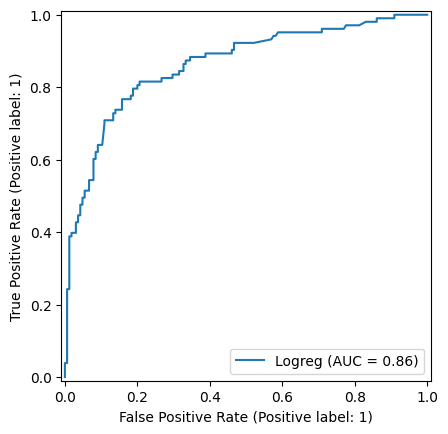

In [65]:
RocCurveDisplay.from_estimator(logreg, X_test_logreg, y_test, name='Logreg')
plt.show()

### XGBoost

In [66]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    # booster='gbtree',
    objective='binary:logistic',
    n_jobs=-1,
    random_state=33,
    eval_metric='logloss'
)

xgb_param_grid = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    n_iter=1000
)

xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.2, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 400, 600],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 2],
                                        'subsample': [0.8, 1.0]},
                   scoring='accuracy', verbose=1)

In [67]:
xgb_search.best_params_

{'subsample': 0.8,
 'reg_lambda': 1,
 'reg_alpha': 1,
 'n_estimators': 600,
 'min_child_weight': 5,
 'max_depth': 7,
 'learning_rate': 0.01,
 'gamma': 0.2,
 'colsample_bytree': 1.0}

In [68]:
xgb = xgb_search.best_estimator_
xgb_train_preds, xgb_train_probs = xgb.predict(X_train), xgb.predict_proba(X_train)
xgb_test_preds, xgb_test_probs = xgb.predict(X_test), xgb.predict_proba(X_test)

In [69]:
print(f'XGB Train accuracy score = {accuracy_score(y_train, xgb_train_preds):.2f}')
print(f'XGB Train precision score = {precision_score(y_train, xgb_train_preds):.2f}')
print(f'XGB Train recall score = {recall_score(y_train, xgb_train_preds):.2f}')
print(f'XGB Test accuracy score = {accuracy_score(y_test, xgb_test_preds):.2f}')
print(f'XGB Test precision score = {precision_score(y_test, xgb_test_preds):.2f}')
print(f'XGB Test recall score = {recall_score(y_test, xgb_test_preds):.2f}')

XGB Train accuracy score = 0.87
XGB Train precision score = 0.87
XGB Train recall score = 0.77
XGB Test accuracy score = 0.82
XGB Test precision score = 0.78
XGB Test recall score = 0.73


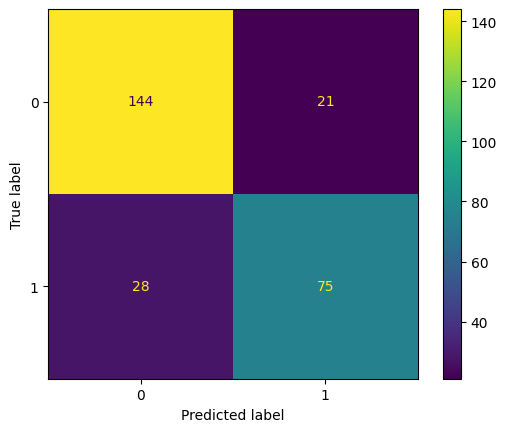

In [70]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.show()

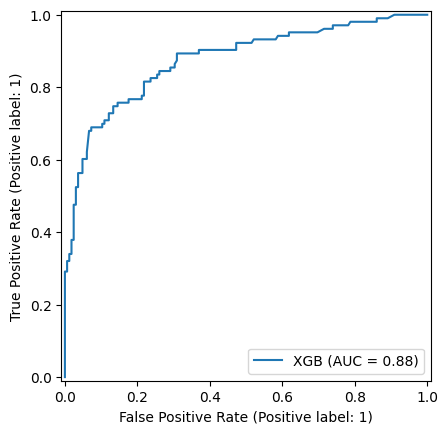

In [71]:
RocCurveDisplay.from_estimator(xgb, X_test, y_test, name='XGB')
plt.show()

#### Обучим модели на всей выборке и сохраним результаты

In [77]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [78]:
X_train, y_train = df_train.drop('Survived', axis=1), df_train['Survived']
X_test = df_test.copy()
X_train, X_test = preprocessing(X_train, X_test)

In [79]:
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [80]:
df_test['Survived'] = preds
df_test = df_test[['PassengerId', 'Survived']]

In [81]:
df_test.to_csv('rf_preds.csv', index=False)

In [82]:
xgb.fit(X_train, y_train)
preds = rf.predict(X_test)
df_test['Survived'] = preds
df_test.to_csv('xgb_preds.csv', index=False)